In [39]:
import jax.numpy as jnp
import jax
import jaxdem as jd
jax.config.update("jax_enable_x64", True)
import numpy as np
import os
from bump_utils import create_clumps
import time
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [89]:
skin = []
mu = []
overflow = []
builds = []
performance = []
radius = []
phi = []
max_occupancy = []

data_root = '/home/mmccraw/dev/data/26-01-01/grant/neighbor-list-characterization/dynamics'
for name in os.listdir(data_root):
    path = os.path.join(data_root, name)
    state = jd.utils.h5.load(os.path.join(path, 'state.h5'))
    system = jd.utils.h5.load(os.path.join(path, 'system.h5'))
    _, _mu, _, _skin = name.split('-')
    mu.append(float(_mu))
    skin.append(float(_skin))
    overflow.append(system.collider.overflow)
    builds.append(system.collider.n_build_times)
    with open(os.path.join(path, 'stats.json'), 'r') as f:
        stats = json.load(f)
    performance.append(state.N * stats['n_steps'] / stats['run_time'])
    radius.append(state.rad.min())
    phi.append(jnp.sum(jnp.pi * state.rad ** 2) / jnp.prod(system.domain.box_size))
    max_occupancy.append(jnp.max(jnp.sum(system.collider.neighbor_list != -1, axis=-1)))

df = pd.DataFrame({
    'skin': skin,
    'mu': mu,
    'overflow': overflow,
    'builds': builds,
    'performance': performance,
    'radius': radius,
    'phi': phi,
    'max_occupancy': max_occupancy,
})

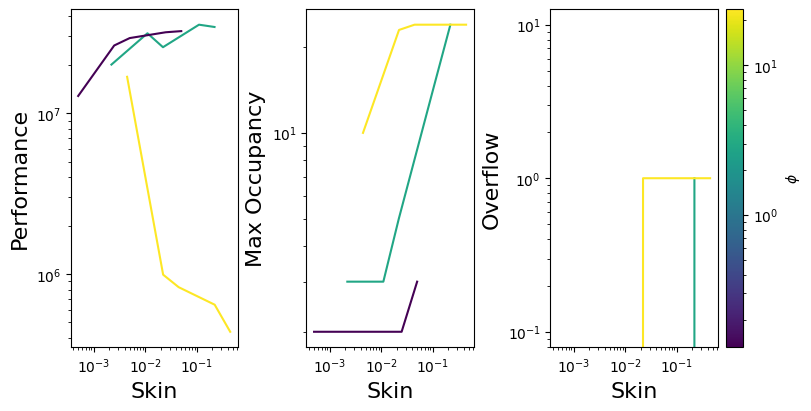

In [94]:
color_mu = False

if color_mu:
    norm = LogNorm(df.mu.min(), df.mu.max())
else:
    norm = LogNorm(df.phi.min(), df.phi.max())
cmap = plt.cm.viridis

fig, ax = plt.subplots(1, 3, figsize=(8, 4), constrained_layout=True, sharex=True)

for mu in df.mu.unique():
    mask = (df.mu == mu)
    _df = df[mask].sort_values(by='skin')
    if color_mu:
        c = cmap(norm(mu))
    else:
        c = cmap(norm(_df.phi.values[0]))
    ax[0].plot(_df.skin * _df.radius, _df.performance, c=c)
    ax[1].plot(_df.skin * _df.radius, _df.max_occupancy, c=c)
    ax[2].plot(_df.skin * _df.radius, _df.overflow, c=c)

for a in ax:
    a.set_xscale('log')
    a.set_yscale('log')
    a.set_xlabel('Skin', fontsize=16)
ax[0].set_ylabel('Performance', fontsize=16)
ax[1].set_ylabel('Max Occupancy', fontsize=16)
ax[2].set_ylabel('Overflow', fontsize=16)

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
if color_mu:
    sm.set_array(np.unique(df.mu))
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')
else:
    sm.set_array(np.unique(df.phi.astype(float)))
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\phi$')
